# Generative Models

So far we have explored the flexibility of deep neural networks for performing supervised learning. After many of the deep-learning methods developed in the last few years have become widespread in the industrial practice, an increasing proportion of academics are now in the process of pushing forward the frontiers of unsupervised learning. 

Autoencoders are equipped with a hidden layer storing a compressed form of the data. Unlike undirected graphical models, autoencoders operate in a **feed-forward mode**. In particular, they consist of two parts: an **encoder** and a **decoder**.

The **encoder** takes high-dimensional observed data as input and compresses it into more condensed representation stored in the hidden layer. The encoder is a **recognition** or **inference network** since it infers a more concise representation of the data.

On the other hand, the **decoder** reconstructs high-dimensional data in the observation space from the hidden latent representations. Therefore, it is the **generative network**. 

The compression paradigm of autoencoders is illustrated in the following figure from the outstanding [Keras Blog post on autoencoders](https://blog.keras.io/building-autoencoders-in-keras.html).

<img src="images/ae.jpg" style="width: 700px;"/>
https://blog.keras.io/building-autoencoders-in-keras.html

The autoencoder part of the notebook follows [Chapter 8.4 of Deep Learning with R](https://jjallaire.github.io/deep-learning-with-r-notebooks/notebooks/8.4-generating-images-with-vaes.nb.html) and the [Keras Blog post on autoencoders](https://blog.keras.io/building-autoencoders-in-keras.html).

## Single-Layer Baseline 

Defining an autoencoder in `keras` is as easy as it gets. We only need to set up two MLPs, each with one hidden layer.

In [35]:
library(keras)
options(repr.plot.width=10, repr.plot.height=5)


input_dim <- 28 * 28
img_size <- c(28, 28)
hidden_dim <- 32

enc <- layer_dense(units = hidden_dim, 
                   activation = 'relu')
dec <- layer_dense(units = input_dim, 
                   activation = 'sigmoid')

auto_in <- layer_input(shape = c(input_dim))
auto_out <- auto_in %>%
    enc %>%
    dec 

auto_enc <- keras_model(auto_in, auto_out)
auto_enc
auto_enc %>% 
    compile(optimizer = 'adam', 
            loss = 'binary_crossentropy')

Model
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_2 (InputLayer)                (None, 784)                     0           
________________________________________________________________________________
dense_5 (Dense)                     (None, 32)                      25120       
________________________________________________________________________________
dense_6 (Dense)                     (None, 784)                     25872       
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
________________________________________________________________________________



### Image Reconstruction

In a first step, we train the autoencoder to reconstruct digits from the MNIST dataset. For this purpose, we normalize the MNIST data.

In [36]:
c(c(data, labels), c(test, test_labels)) %<-% dataset_mnist() 
x_mnist <- array_reshape(data / 255, 
                         dim = c(dim(data)[1], input_dim)) 
test <- array_reshape(test / 255, 
                      dim = c(dim(test)[1], input_dim)) 

In [37]:
auto_enc %>% 
    fit(x_mnist, 
        x_mnist, 
        epochs = 10, 
        batch_size = 128)

Now, we visualize the reconstructed images.

In [48]:
plot_img <- function(idx, data){
    par(mfrow=c(1,2)) 
    plot(as.raster(array_reshape(data[idx,], img_size)))
    
    reconst <- auto_enc %>%
                predict(data[idx: (idx + 1),])
    plot(as.raster(array_reshape(reconst[1,], img_size)))
}

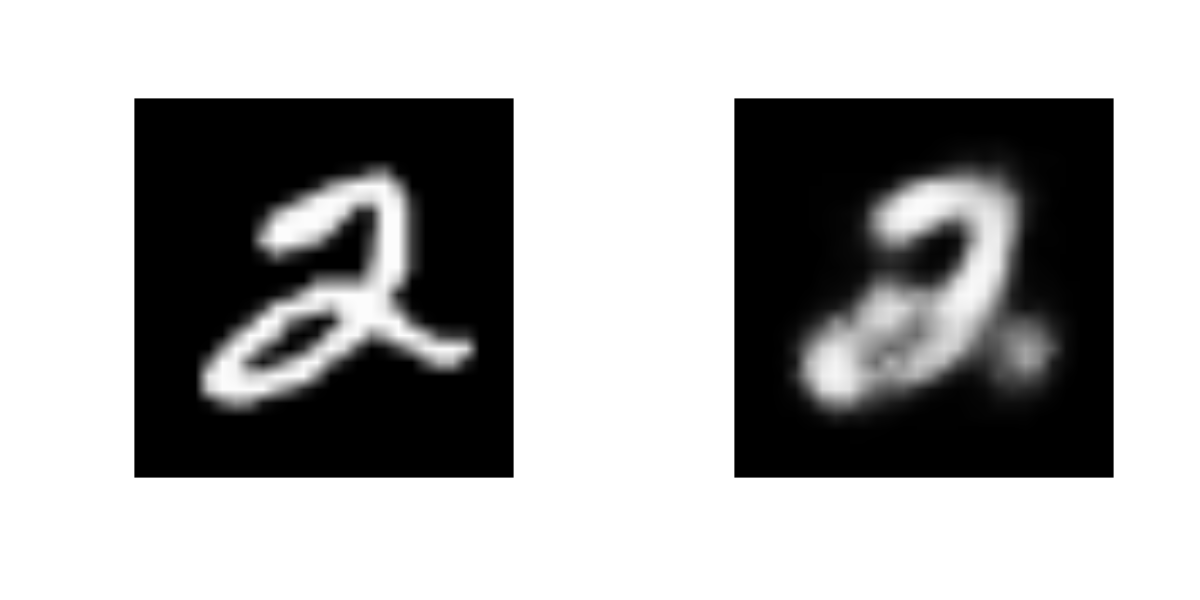

In [50]:
plot_img(6,  x_mnist)

## Image Denoising

In the next step, we add noise to the digits to test if the autoencoder can still reconstruct the digits under more difficult circumstances.

In [51]:
noise_scale <- .5

noise <- array_reshape(noise_scale * rnorm(length(x_mnist)),
                       dim = dim(x_mnist))
x_noisy <- pmax(pmin(x_mnist + noise, 1), 0)

noise <- array_reshape(noise_scale * rnorm(length(test)), 
                       dim = dim(test))
test_noisy <- pmax(pmin(test + noise, 1), 0)

Let's visualize the noisy images and see how well the autoencoder can reconstruct the digits.

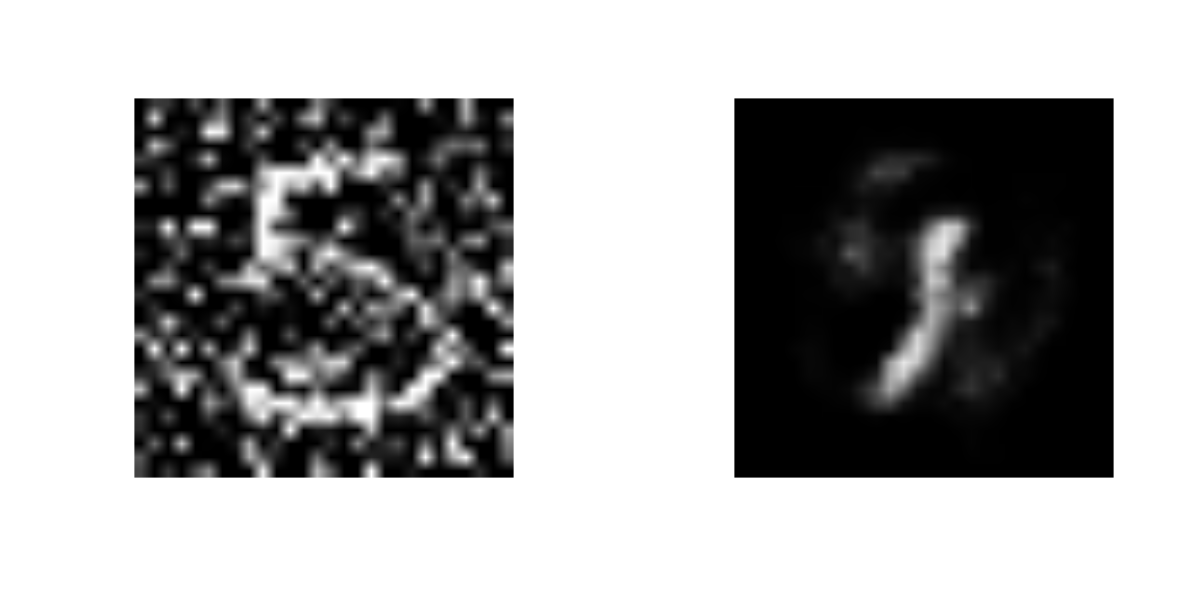

In [52]:
plot_img(16, test_noisy)

Now, we train the autoencoder with the noisy images, therefore obtaining a **denoising autoencoders**.

In [53]:
auto_enc %>% 
    fit(x_noisy, 
        x_mnist, 
        epochs = 10, 
        batch_size = 128)

Repeating the visualization after the training, we see that the quality is a bit better.

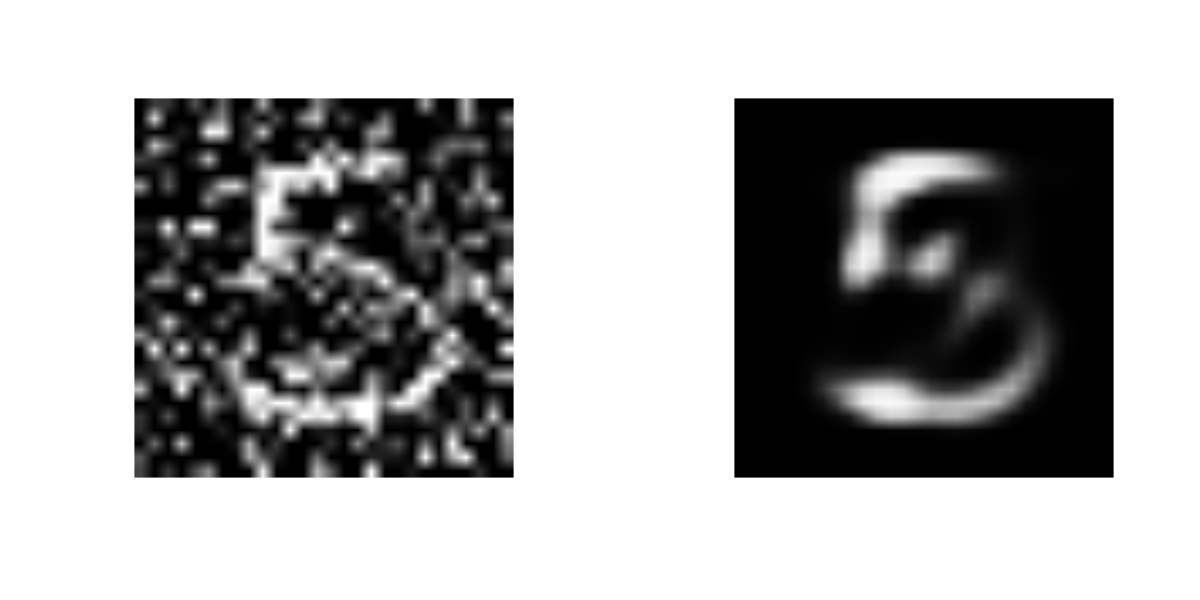

In [54]:
plot_img(16, test_noisy)

## Convolutional Autoencoder

The single-layer autoencoder already reconstructs images at a decent quality. However, in order to make use of the locality of information inherent in image data, state-of-the-art autoencoders rely on convolutional architectures. For both the encoder and the decoder, we use a 3-layer structure suggested in https://blog.keras.io/building-autoencoders-in-keras.html.

In [55]:
filter_size = 32

enc <- keras_model_sequential() %>%
        layer_conv_2d(filters = filter_size, 
                      kernel_size = 3, 
                      padding = 'same',
                      activation = 'relu', 
                      input_shape = c(img_size, 1)) %>%
        layer_flatten() %>%
        layer_dense(units = hidden_dim, activation = 'relu')

dec <- keras_model_sequential() %>%
        layer_dense(input_dim, activation = 'sigmoid')

In [56]:
auto_enc = keras_model_sequential() %>%
    enc %>%
    dec
auto_enc %>% 
    compile(optimizer='adam', 
            loss='binary_crossentropy')

We convert the MNIST-data back to the original shape and then train the convolutional autoencoder. 

In [61]:
x_noisy_resh = array_reshape(x_noisy, 
                             dim = c(dim(x_noisy)[1], c(img_size, 1)))
test_noisy_resh = array_reshape(test_noisy, 
                               dim = c(dim(test_noisy)[1], c(img_size, 1)))

In [62]:
auto_enc %>% 
    fit(x_noisy_resh, 
        x_mnist, 
        epochs = 20, 
        batch_size = 128)

The visualization confirms that the convolutional reconstructs the image a bit better.

In [68]:
plot_img_conv <- function(idx, data){
    par(mfrow=c(1,2)) 
    plot(as.raster(array_reshape(data[idx,,,], img_size)))
    
    reconst <- auto_enc %>% 
            predict(array_reshape(data[idx: (idx + 1),,,], 
                                  c(2, img_size, 1)))
    plot(as.raster(array_reshape(reconst[1,], img_size)))
}

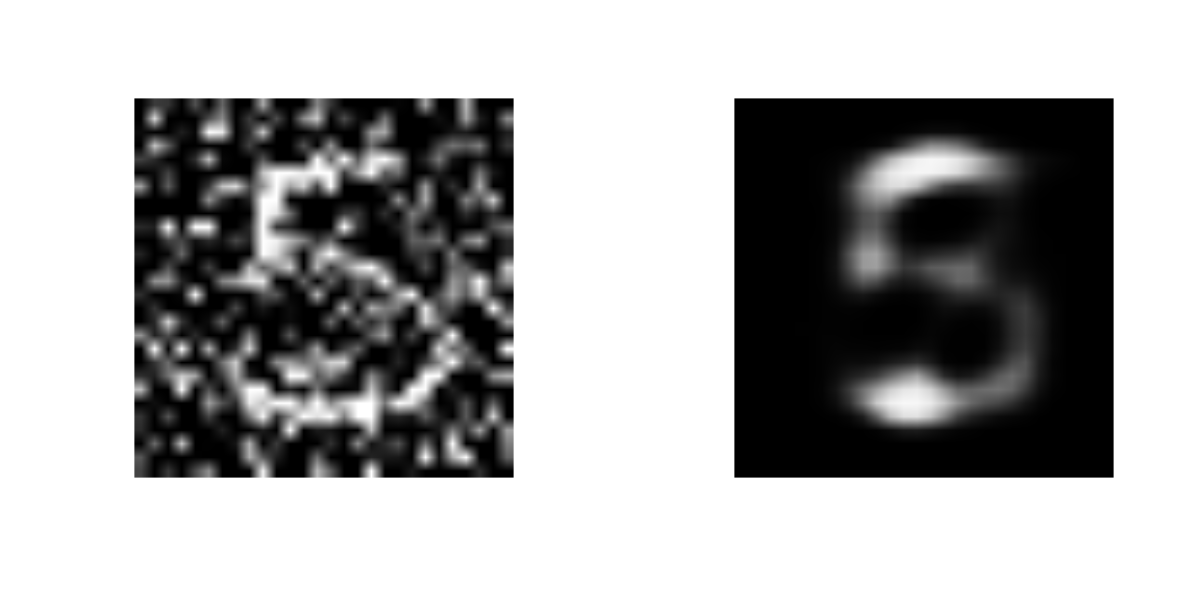

In [70]:
plot_img_conv(16,  test_noisy_resh)

#### 8.35

#### 9.15

## Variational Autoencoder

Autoencoders described above have the disadvantage of making only weak progress towards learning a useful latent-space representation. The reason is that only those parts of the latent space that are close to the image of a noisy digit are encouraged to produce a useful high-dimensional representation. 

This becomes apparant when increasing the noise level: plugging in white noise results in a small white spot.

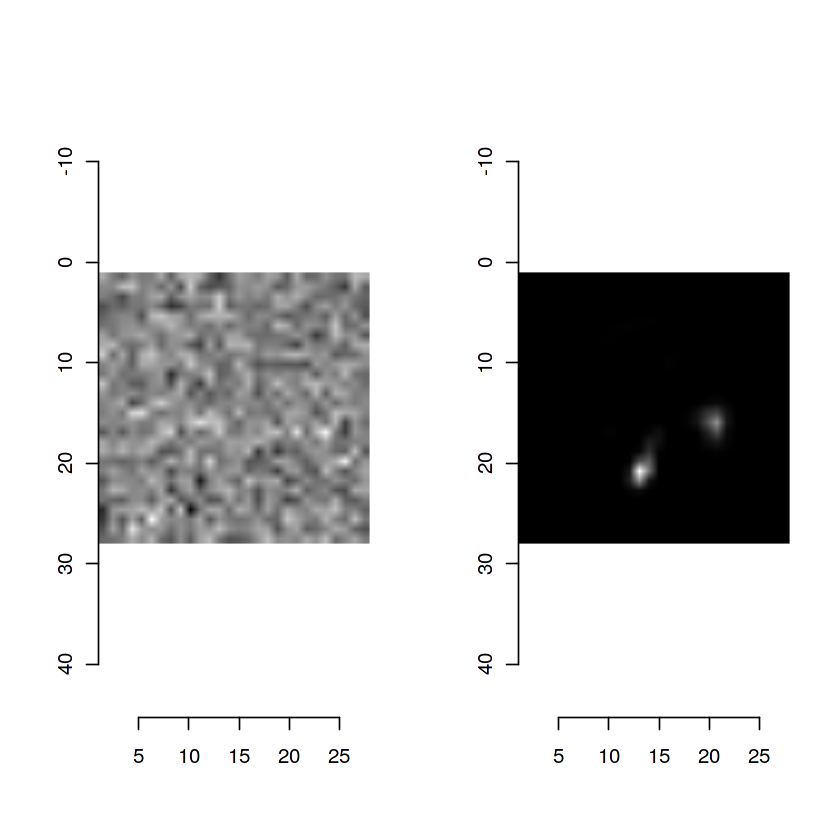

In [237]:
noise <- array_reshape( pmax(pmin(rnorm(length(x_noisy_resh)), 1), 0), 
                      dim = dim(x_noisy_resh))
plot_img(5, noise)

**Variational Autoencoders (VAEs)** introduced by [D. Kingma & M. Welling](https://openreview.net/forum?id=33X9fd2-9FyZd) avoid this problem by mapping a high-dimensional observed data point to the *parameters of a distribution* on the latent space, rather than to a single point in the latent space. A similar approach is taken by [D. J. Rezende, S. Mohamed & D. Wierstra](http://proceedings.mlr.press/v32/rezende14.html). Moreover, VAEs are trained with an objective penalizing if the distribution moves too far away from a simple prior. These changes encourage a latent representation capturing the original distribution far better when compared to deterministic autoencoders.

### Variational Inference and the Evidence Lower Bound

The guiding principle behind VAEs is **variational inference**. Suppose, we have a candidate parametric density $p(x) = p_\theta(x)$ for describing the data and we want to optimize the parameters $\theta$ via maximum likelihood. Suppose that the distribution is constructed with the help of latent variables $z$ in the sense that
$$p(x) = \int p(x|z) p(z) {\rm d}z$$
In particular, if q(z) is any probability density on the latent space, then Jensen's inequality gives that
$$
\log \int  p(z) \frac{p(x|z)}{q(z)}q(z) {\rm d}z  \ge  \int\log  \Big( p(z) \frac{p(x|z)}{q(z)}\Big)q(z) {\rm d}z 
= \mathbb{E}_q[\log(p(x|z))] - KL(q|p),
$$
where $KL(q|p) = \mathbb{E}_q [\log\big(\frac{q(z)}{p(z)}\big)]$ is the **Kullback-Leibler distance** between $q$ and $p$. The right-hand side is known as **evidence lower bound (ELBO)**. In variational inference, the ELBO becomes a surrogate objective for the maximization of $\log p(x)$. As we will see, this is often feasible.

If $q(z) = p(z|x)$, then the ELBO becomes an equality and the optimization task essentially reduces to the **EM** algorithm. However, the computation of the latent distribution $p(z|x)$ is often intractable, so that we have to approximate $p(z|x)$ by more tractable parametric **approximate posterior** $q_{\phi}(z|x)$. 

Typically, $q(z) = q(z|x)$ is data-dependent and we therefore call it the **approximate posterior**.

The expression $-\mathbb{E}_{q(z|x)}[\log(p(x|z))]$ is the **reconstruction loss**. It is a substitute for the reconstruction objective in the classical autoencoder. Indeed, it incentivizes latent representations assigning high likelihood to the originating observed data point $x$.

The Kullback-Leibler distance serves as a **regularization loss**. It discourages an overly complicated approximate posterior $q(z|x)$, thereby ensuring good generalization properties. This regularization contribution is missing in the classical autoencoders and therefore leads to the dissatisfactory latent representation described above.

Although the ELBO is only a surrogate objective, it still serves as a metric for assessing the quality of the model fit.

### Example: Digit Generation

Next, we discuss in detail the example from https://jjallaire.github.io/deep-learning-with-r-notebooks/notebooks/8.4-generating-images-with-vaes.nb.html in the context of generating MNIST images.

### Recognition Network

In the recognition network, we first pass the image through four conv and one dense layer to arrive at a useful condensed representation `h`.

In [2]:
library(keras)
img_size <- c(28, 28)
latent_dim <- 2  

x <- layer_input(shape = c(img_size, 1))
x_transf <- x %>% 
  layer_conv_2d(filters = 32, kernel_size = 3, padding = "same", 
                activation = "relu") %>% 
  layer_conv_2d(filters = 64, kernel_size = 3, padding = "same", 
                activation = "relu", strides = c(2, 2)) %>%
  layer_conv_2d(filters = 64, kernel_size = 3, padding = "same", 
                activation = "relu") %>%
  layer_conv_2d(filters = 64, kernel_size = 3, padding = "same", 
                activation = "relu") 

shape_before_flattening <- k_int_shape(x_transf)
h <- x_transf %>% 
  layer_flatten() %>% 
  layer_dense(units = 512, activation = "relu")

Then, we parametrize the mean and log-variance of the encoder via single-layer MLPs. 

In [3]:
z_mean <- h %>% 
  layer_dense(units = latent_dim)
z_logvar <- h %>% 
  layer_dense(units = latent_dim)

Finally, to draw a sample from the corresponding Gaussian, we introduce a *Lambda*-layer.

In [5]:
sample <- function(args){
    c(z_mean, z_logvar) %<-% args
    k_random_normal(shape = c(latent_dim), 
                    mean = z_mean, 
                    stddev = k_exp(z_logvar/2.))
}
    
enc_x <- layer_lambda(f = sample)(list(z_mean, z_logvar))
encoder <- keras_model(x, enc_x)

### Generative Network

The decoder first reshapes the latent into an image size and then applies deconvolutions.

In [6]:
z <- layer_input(latent_dim)#k_int_shape(enc_x)[-1])
dec_z <- z %>% 
  layer_dense(units = prod(as.integer(shape_before_flattening[-1])),
              activation = "relu") %>% 
  layer_reshape(target_shape = shape_before_flattening[-1]) %>% 
  layer_conv_2d_transpose(filters = 32, 
                          kernel_size = 3, 
                          padding = "same",
                          activation = "relu", 
                          strides = c(2, 2)) %>%  
  layer_conv_2d(filters = 1, 
                kernel_size = 3, 
                padding = "same",
                activation = "sigmoid")  

Hence, the decoder becomes

In [7]:
decoder <- keras_model(z, dec_z) 

### Loss Function

To train the autoencoder, we need to implement the loss function derived from the ELBO. We start by noting that the reconstruction loss
$$-\log p(x| z; \theta) = \sum_{i, j \le 28} -\log p\big(x(i,j)| z; \theta\big),$$
is simply the binary crossentropy error for the problem of predicting the white pixels in the image.

It remains to deal with the Kullback-Leibler distance

$$\mathbb{E}_{\varepsilon \sim \mathcal{N}(0; I_n)}\Big[\log\Big(\frac{({\rm det}(\Sigma(x; \phi)))^{-1/2}\mathcal{N}_{}(\varepsilon;0, I_n )}{p(\mu(x; \phi) + \varepsilon \Sigma(x; \phi)))}\Big)\Big]$$

If the prior $p(z)$ is also standard Gaussian, then the above Kullback-Leibler distance becomes up to constants
$$-\frac12\sum_{k \le n}\log(\sigma_k^2(x; \phi)) - \mu_k(x; \phi)^2 - \sigma_k(x; \phi)^2$$

We combine the two losses into the ELBO.

In [8]:
kl_weight <- 5e-4

elbo <- function(x, dec_enc_x) {
  x <- k_flatten(x)
  dec_enc_x <- k_flatten(dec_enc_x)
  xent_loss <- metric_binary_crossentropy(x, dec_enc_x)
  kl_loss <- - k_mean(
     z_logvar - k_square(z_mean) - k_exp(z_logvar), 
    axis = -1L
  )
  k_mean(xent_loss + kl_weight * kl_loss)
}

In order to implement the loss function of VAE, we need a custom layer as in https://jjallaire.github.io/deep-learning-with-r-notebooks/notebooks/8.4-generating-images-with-vaes.nb.html.

In [9]:
library(R6)

CustomVariationalLayer <- R6Class("CustomVariationalLayer",               
  inherit = KerasLayer,
  public = list(
    call = function(inputs, mask = NULL) {
      x <- inputs[[1]]
      dec_enc_x <- inputs[[2]]
      loss <- elbo(x, dec_enc_x)
      self$add_loss(loss, inputs = inputs)
      x
    }
  )
)

layer_variational <- function(object) 
  create_layer(CustomVariationalLayer, object, list())

This was the last missing piece for the definition of the VAE

In [11]:
dec_enc_x <- decoder(enc_x)
dummy <- list(x, dec_enc_x) %>% 
  layer_variational() 

vae <- keras_model(x, dummy)
vae %>% 
    compile(optimizer = "rmsprop", 
            loss = NULL)
vae

Model
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_1 (InputLayer)      (None, 28, 28, 1) 0                                   
________________________________________________________________________________
conv2d_1 (Conv2D)         (None, 28, 28, 32 320      input_1[0][0]              
________________________________________________________________________________
conv2d_2 (Conv2D)         (None, 14, 14, 64 18496    conv2d_1[0][0]             
________________________________________________________________________________
conv2d_3 (Conv2D)         (None, 14, 14, 64 36928    conv2d_2[0][0]             
________________________________________________________________________________
conv2d_4 (Conv2D)         (None, 14, 14, 64 36928    conv2d_3[0][0]             
________________________________________________________________________________
flatten_1 (Flatten)   

### Training

Now, we load the MNIST data...

In [20]:
c(c(x_train, y_train), c(x_test, y_test)) %<-% dataset_mnist() 
x_train <- array_reshape(x_train / 255, 
                         dim =c(dim(x_train), 1))
x_test <- array_reshape( x_test / 255, 
                        dim =c(dim(x_test), 1))

... and start training.

In [23]:
vae %>% fit(
  x = x_train, y = NULL,
  epochs = 10,
  batch_size = 2048,
  validation_data = list(x_test, NULL)
)

We now sample points from the two-dimensional latent space and convert them into digits as done in https://jjallaire.github.io/deep-learning-with-r-notebooks/notebooks/8.4-generating-images-with-vaes.nb.html.

In [273]:
n <- 15            
digit_size <- 28   
batch_size <- 16
grid_x <- qnorm(seq(.05, .95, length.out = n))
grid_y <- qnorm(seq(.05, .95, length.out = n))
op <- par(mfrow = c(n, n), 
          mar = c(0,0,0,0), 
          bg = "black")

for (i in 1:length(grid_x)) {
  yi <- grid_x[[i]]
  for (j in 1:length(grid_y)) {
    xi <- grid_y[[j]]
    z_sample <- matrix(c(xi, yi), 
                       nrow = 1, ncol = 2)
    z_sample <- t(replicate(batch_size, z_sample, simplify = "matrix"))
    x_decoded <- decoder %>%
      predict(z_sample, batch_size = batch_size)
    digit <- array_reshape(x_decoded[1,,,], 
                           dim = c(digit_size, digit_size))
    plot(as.raster(digit))
  }
}
par(op)

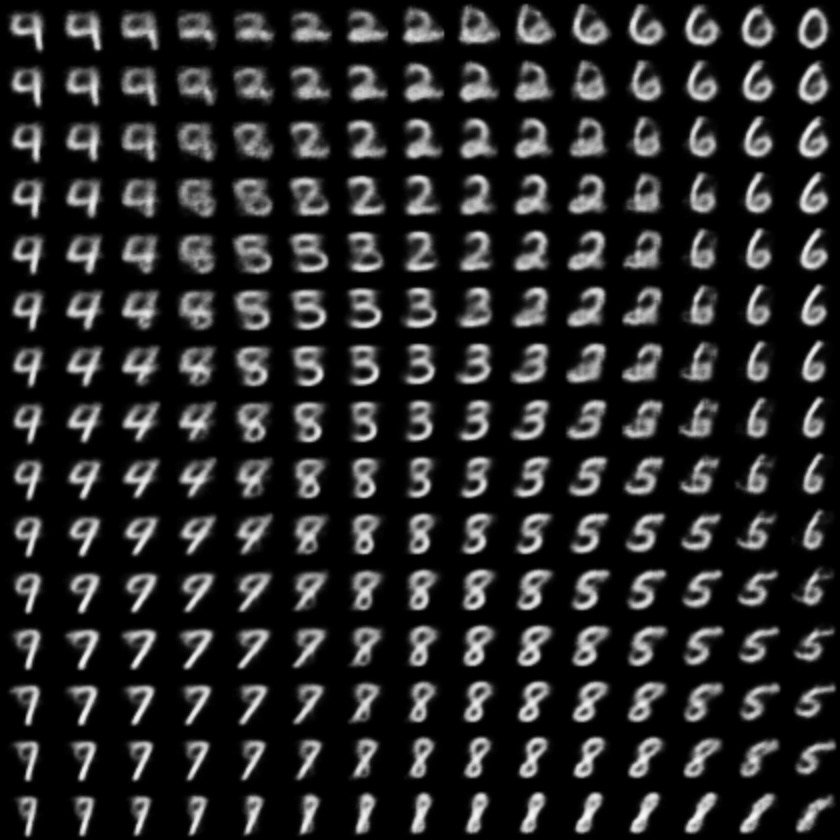

### Reparametrization Trick

In order to maximize the ELBO with respect to the parameters $\theta$ of $p(x|z; \theta)$ and $\phi$ of $q(z|x; \phi)$, we would like to resort to [stochastic gradient descent](./backprop.ipynb). Typically, $p(x|z; \theta)$ is a neural network with input $z$ and weights $\theta$, so that computing gradients with respect to $\theta$ is not an issue. 

On the other hand, computing gradients with respect to $\phi$ is not entirely obvious, since the density $q$ is also used to draw samples in the ELBO. Here, the ingenious **reparametrization trick** proposed by [D. Kingma & M. Welling](https://openreview.net/forum?id=33X9fd2-9FyZd) enters the stage. We explain this trick for the example when $q$ is Gaussian.

Typically, we assume the mean $\mu(x)$ and diagonal covariance $\Sigma(x)$ of $q(z|x; \phi) \sim \mathcal{N}(z; \mu_\phi(x), \sigma_\phi(x))$ to be nonlinear functions of the data point $x$. More precisely, $(\mu(x), \sigma_\phi(x)) = g_\phi(x)$, where $g_\phi$ is a deep net with  weights $\phi$. Then, we draw samples $q(z|x; \phi)$ via $z = \mu_\phi(x) + \varepsilon \sigma_\phi(x),$ where $\varepsilon \sim \mathcal{N}(0; I_n)$ is standard normal. 

This reparametrization has the advantage that the reconstruction error becomes
$$\mathbb{E}_{\varepsilon \sim \mathcal{N}(0; I_n)}[\log p(x| \mu_\phi(x) + \varepsilon \sigma_\phi(x); \theta)].$$

Now, both the weights of the inference and of the generative network appear inside the expectation, so that we can optimize the ELBO via gradient descent.

#### 10.05

#### 10.45

## GAN

VAE  can generate promising candidates of images with high inherent complexities, such as faces. However, the images obtained in this manner tend to be blurry
<img  src="images/celebA.png"  width="500">
https://github.com/yzwxx/vae-celebA

This is due to the ELBO as training objective. Here, the reconstruction error is given as $-\mathbb{E}_{x \sim \mathsf{data}}\mathbb{E}_{z \sim q(\cdot|x)}[\log p(x|z)]$, which results in a massive penalty if we encounter a data point with very low probability under $p(\cdot|z)$.

A radically new concept for generative models are **Generative Adversarial Networks (GANs)** as introduced in a [landmark paper](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf%20(https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) by Ian Goodfellow et. al. in 2014. The idea as simple as it is intriguing. The generative task is set up as an adversarial competition between two neural networks: While the goal of the **generator** is to produce realistically-looking images of cats, the job of the **discriminator** is tell actual images from generated ones. Then, the generator can take false decisions of the discriminator as cues on how to produce better images.

<img id="gab" src="images/ganGame.png"  width="900">

The code in this notebook is adapted from a wonderful [AC-GAN implementation](https://github.com/rstudio/keras/blob/master/vignettes/examples/mnist_acgan.R) in the Keras example section and from [Chapter 8.5 of Deep Learning with R](https://jjallaire.github.io/deep-learning-with-r-notebooks/notebooks/8.5-introduction-to-gans.nb.html).

## Generator versus Discriminator

It's not only that the concept behind GANs can be explained in one sentence to a man in the street, also the mathematical concept is just as elegant as $E = mc^2$! It is based on the following minimax problem:
\begin{align} \min_G \max_D \mathbb{E}_{x \sim p_{\mathsf{data}}}[\log D(x)] + \mathbb{E}_{z \sim p_{\mathsf{noise}}}[\log( 1 - D(G(z)))],
\end{align}
where $G$ and $D$ denote the generator and the discriminator, respectively.

For fixed generator, the inner maximization means that the discriminator is trained to minimize the cross-entropy error for the classification problem of true vs. fake images. The outer minimization means that the generator tries to make this task as difficult as possible.

Heuristically speaking, training the generator is more difficult than training the discriminator. For instance, for a fixed generator, the inner maximization problem has a closed-form solution.

**Theorem**

For fixed $G$ the solution of the optimization problem
$$ \max_D \mathbb E_{x \sim p_{\mathsf{data}}}[\log D(x)] + \mathbb E_{z \sim p_{\mathsf{noise}}}[\log(1 - D(G(z)))]$$
is given by 
$$D(x) = \frac{p_\mathsf{data}(x)}{p_\mathsf{data}(x) + p_{G}(x)},$$
where $p_{G}$ is the probability density of $G(Z)$ with $Z \sim p_{\mathsf{noise}}$. The value at the maximum is given by
$$\log(4) + \mathsf{JSD}(p_{\mathsf{data}}, p_G),$$
where $\mathsf{JSD}(p_{\mathsf{data}}, p_G)$ denotes the **Jensen-Shannon Divergence** between $p_{\mathsf{data}}$ and $p_G$, i.e., 
$$\mathsf{JSD}(p_{\mathsf{data}} = \mathsf{KL}(p_\mathsf{data}|(p_{\mathsf{data}} + p_G)/2) + \mathsf{KL}(p_G|(p_{\mathsf{data}} + p_G)/2),$$

Typically, both discriminator and generator are implemented as CNNs. Here are examples that we will use below to generate MNIST digits.

### Disriminator

In [1]:
library(keras)
library(abind)
k_set_image_data_format('channels_first')

disc_cnn <- function(){
    cnn <- keras_model_sequential()%>%
    layer_conv_2d(
      32, c(3,3), padding = "same", strides = c(2,2),
      input_shape = c(1, 28, 28)
    ) %>%
    layer_activation_leaky_relu() %>%
    layer_dropout(0.3) %>%

    layer_conv_2d(64, c(3, 3), padding = "same") %>%
    layer_activation_leaky_relu() %>%
    layer_dropout(0.3) %>%  

    layer_conv_2d(128, c(3, 3), padding = "same", strides = c(2,2)) %>%
    layer_activation_leaky_relu() %>%
    layer_dropout(0.3) %>%  

    layer_conv_2d(256, c(3, 3), padding = "same") %>%
    layer_activation_leaky_relu() %>%
    layer_dropout(0.3) %>%  
    layer_flatten()
    
    cnn
}

disc_cnn()

Model
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_1 (Conv2D)                   (None, 32, 14, 14)              320         
________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)           (None, 32, 14, 14)              0           
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 32, 14, 14)              0           
________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, 64, 14, 14)              18496       
________________________________________________________________________________
leaky_re_lu_2 (LeakyReLU)           (None, 64, 14, 14)              0           
________________________________________________________________________________
dropout_2 (Dropout)   

### Generator

In [2]:
latent_size <- 100

gen_cnn <- function(){
    cnn <- keras_model_sequential()%>%
    layer_dense(1024, input_shape = latent_size, activation = "relu") %>%
    layer_dense(128*7*7, activation = "relu") %>%
    layer_reshape(c(128, 7, 7)) %>% 
    
    layer_upsampling_2d(size = c(2, 2)) %>%
    layer_conv_2d(
      256, c(5,5), padding = "same", activation = "relu",
      kernel_initializer = "glorot_normal"
    ) %>%
    
    layer_upsampling_2d(size = c(2, 2)) %>%
    layer_conv_2d(
      128, c(5,5), padding = "same", activation = "tanh",
      kernel_initializer = "glorot_normal"
    ) %>%
    layer_conv_2d(
      1, c(2,2), padding = "same", activation = "tanh",
      kernel_initializer = "glorot_normal")
    
    cnn
}

gen_cnn()

Model
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_1 (Dense)                     (None, 1024)                    103424      
________________________________________________________________________________
dense_2 (Dense)                     (None, 6272)                    6428800     
________________________________________________________________________________
reshape_1 (Reshape)                 (None, 128, 7, 7)               0           
________________________________________________________________________________
up_sampling2d_1 (UpSampling2D)      (None, 128, 14, 14)             0           
________________________________________________________________________________
conv2d_5 (Conv2D)                   (None, 256, 14, 14)             819456      
________________________________________________________________________________
up_sampling2d_2 (UpSam

## Example: GAN for MNIST`

Now, we discuss a simplified version of the [GAN example](https://github.com/keras-team/keras/blob/master/examples/mnist_acgan.py) from the keras repository. In fact, in the example not only achieves to generate realistically-looking digits, but uses the resulting digits as data augmentation to improve the discriminator. This concept is known as **Auxiliary Classifier GAN (AC-GAN)** and was introduced by [Augustus Odena, Christopher Olah, Jonathon Shlens](https://arxiv.org/abs/1610.09585). Loosely speaking, the discriminator is not only trained to spot fake digits, but also to classify real ones correctly.

First, we initialize the discriminator and optimize it via cross-entropy.

In [3]:
# Adam parameters suggested in https://arxiv.org/abs/1511.06434
adam_lr = 2e-4
adam_beta_1 = 0.5
optimizer = optimizer_adam(lr=adam_lr, beta_1=adam_beta_1)

In [9]:
  image <- layer_input(shape = c(1, 28, 28))
  features <- disc_cnn()(image)

  fake <- features %>% 
    layer_dense(1, activation = "sigmoid")
  
  aux <- features %>%
    layer_dense(10, activation = "softmax")
  
discriminator <- keras_model(image, list(fake, aux))
discriminator %>% compile(
  optimizer = optimizer_adam(lr = adam_lr, beta_1 = adam_beta_1),
  loss = list("binary_crossentropy", "sparse_categorical_crossentropy")
)

Next, we build the generator. It transforms noise into fake images.

In [10]:
latent <- layer_input(shape = list(latent_size))

image_class <- layer_input(shape = list(1))
cls <-  image_class %>%
    layer_embedding(
      input_dim = 10, output_dim = latent_size, 
      embeddings_initializer='glorot_normal'
    ) %>%
    layer_flatten()

h <- layer_multiply(list(latent, cls))
fake_image <- gen_cnn()(h)
  
generator <- keras_model(list(latent, image_class), fake_image)
generator

Model
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_12 (InputLayer)     (None, 1)         0                                   
________________________________________________________________________________
embedding_3 (Embedding)   (None, 1, 100)    1000     input_12[0][0]             
________________________________________________________________________________
input_11 (InputLayer)     (None, 100)       0                                   
________________________________________________________________________________
flatten_6 (Flatten)       (None, 100)       0        embedding_3[0][0]          
________________________________________________________________________________
multiply_3 (Multiply)     (None, 100)       0        input_11[0][0]             
                                                     flatten_6[0][0]            
______________________

Since the generator can only learn from cues by the discriminator, its training is set up in a joint model. Again the binary cross-entropy appears as training objective.

In [11]:

latent_comb <- layer_input(shape = list(latent_size))
image_class_comb <- layer_input(shape = list(1), dtype = "int32")

fake <- generator(list(latent_comb, image_class_comb))

# Only want to be able to train generation for the combined model
freeze_weights(discriminator)
results <- discriminator(fake)

combined <- keras_model(list(latent_comb, image_class_comb), results)
combined %>% compile(
  optimizer = optimizer_adam(lr = adam_lr, beta_1 = adam_beta_1),
  loss = list("binary_crossentropy", "sparse_categorical_crossentropy")
)
combined

Model
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_13 (InputLayer)     (None, 100)       0                                   
________________________________________________________________________________
input_14 (InputLayer)     (None, 1)         0                                   
________________________________________________________________________________
model_5 (Model)           (None, 1, 28, 28) 8172521  input_13[0][0]             
                                                     input_14[0][0]             
________________________________________________________________________________
model_4 (Model)           [(None, 1), (None 525835   model_5[1][0]              
Total params: 8,698,356
Trainable params: 8,172,521
Non-trainable params: 525,835
________________________________________________________________________________



Now, we load the MNIST data

In [12]:
c(c(x_train, y_train), c(x_test, y_test)) %<-% dataset_mnist() 

x_train <- (x_train - 127.5)/127.5
ntrain <- dim(x_train)[1]
x_train <- array_reshape(x_train, c(ntrain, 1, 28, 28))

The training of the generator is the most exciting. We let the generator create fake images and then try to fool the discriminator by maintaining that all of the fake images are real ones.

In [13]:
train_gen <- function(comb, num_classes=10, batch_size=128){
    noise <- runif(2 * batch_size * latent_size, min = -1, max = 1) %>%
      matrix(ncol = latent_size)
    sampled_labels <- sample(0:9, size = 2 * batch_size, replace = T)%>%
      matrix(ncol = 1)
    
    trick <- rep(1, 2 * batch_size) %>% 
        matrix(ncol = 1)
    
    train_on_batch(
        comb, 
        list(noise, sampled_labels),
        list(trick, sampled_labels)
    )
}

In the main loop, we alternate between training the discriminator and the generator.

In [ ]:
epochs = 100
batch_size = 100

for (idx in 1:100){
    for(j in 1:3)
         train_gen(combined) 
    train_disc(discriminator, generator)
}           

The training of the discriminator is more standard, although here the generation of training data is more involved.

In [16]:
train_disc <- function(discriminator, generator){
    c(images, classes) %<-% create_train_data( x_train, y_train, generator)
    fake <- c(rep(1L, batch_size), rep(0L, batch_size)) %>%
        matrix(ncol = 1)
    train_on_batch(discriminator, x = images, y = list(fake, classes))
}

The most involved part is the creation of training samples.

In [17]:
create_train_data <- function(x_train, y_train, generator){
    
    batch <- sample.int(ntrain, size = batch_size)
        
    #classes
    c(true_classes, fake_classes) %<-% create_train_classes(batch, y_train)
    
    #true images
    true_images =  x_train[batch,,,,drop = FALSE]

    #fake images
    noise <- runif(n = batch_size * latent_size, min = -1, max = 1) %>%
      matrix(nrow = batch_size, ncol = latent_size)
    fake_images <-  predict(generator, list(noise, fake_classes)) 
    
    X <- abind(true_images, fake_images, along = 1)
    aux_y <- c(true_classes, fake_classes) %>% 
        matrix(ncol = 1)
    
    list(X, aux_y)
    }

For the AC GANs we also need to create class labels.

In [19]:
 create_train_classes <- function(batch, y_train){
    #true classes
     true_classes <- y_train[batch]
     
    #fake classes
    fake_classes <- (sample.int(10, size = batch_size, replace = T) - 1) %>%
      matrix(ncol = 1)
    list(true_classes, fake_classes)
}

## Visualization

Now, we visualize the generated digits.

In [14]:
noise <- runif(10 * latent_size, min = -1, max = 1) %>%
    matrix( ncol = latent_size)

sampled_labels <- 0:9 %>%
    matrix(ncol = 1)

generated_images <- predict(
    generator,    
    list(noise, sampled_labels)
)


In [ ]:
pmin((generated_images[5,,,] + 1.01)/2, 1) %>%
as.raster() %>%
    plot()

## Challenges

As of today, GANs are the generative framework producing the most visually appealing picture. At the same time, researchers are working intensively on removing fundamental deficiencies of GANs.

### Mode Collapse

Images created by GANs frequently lack the diversity of real data. Loosely speaking, once the generator has found a way to fool the discriminator, it continues to exploit this loophole since there is little incentive to explore further options. One promising counter-measure is [Mini-batch discrimination](https://openreview.net/forum?id=rJFs4tRF). Here, the discriminator decides not on a single training example but on an entire mini-batch. If the examples in the mini-batch are all too similar, then he can confidently classify it as a fake.

### Overpowerful Discriminator

Although training GANs is a two-player game, it is not a fair competition. Indeed, the recognition task of the generator is far less involved than the creation task of the generator. Hence, it may happen that the discriminator wins the game in the early phase of the training process, so that the generator will never receive any training signals.

In order to counteract this trend, we can add more randomness and artificially add handicaps for the discriminator:

1. Apply dropout in the discriminator and introduce soft labels in discriminator training.
2. Increase the gradient flow to the generator by using Leaky ReLUs and relying on strided convolutions instead of max-pooling.

### Metrics

Despite being only a lower bound, in VAE the ELBO provides an indication on the quality of the generated images and also on when to stop the training process. In contrast, the training of GANs is a minimax game between two players of competing interests, so that it is not clear which metric to choose. A small loss for the discriminator would not yield any information on the quality of the generator and vice versa.

When trained on Imagenet, a popular metric for assessing the quality of GANs is the [Inception Score](https://openreview.net/forum?id=rJFs4tRF):
$$\exp(\mathbb{E}_{x \sim p_G}[\mathsf{KL}(p(y|x))||p(y)]),$$
where $p$ denotes the class distribution of the generated images. Loosely speaking, this metric incorporates two objectives:
1. A highly spiked conditional distribution means that a CNN is super-confident about membership to a specific class. This is an indicator for good image quality
2. A high-entropy marginalized label distribution $p(y)$ means image diversity.


### GANs in NLP

Although state-of-the-art GANs generate stunningly real images, they are not yet capable of writing high-quality text. The reason is that sampling words is inherently non-differentiable, so that we are thrown outside the domain of backpropagtion. This problem applies to VAE for the same reason, so that progress in the domain of NLP remains one of the major unsolved research challenges in generative models.

## Wasserstein GAN

Replacing Jensen-Shannon divergence by the Wasserstein distance, we arrive at the concept of **Wasserstein GANs** introduced by [Martin Arjovsky, Soumith Chintala and Léon Bottou](https://arxiv.org/abs/1701.07875). For probability measures on compact spaces, the **Wasserstein distance** metrizes weak convergence and is given by:
$$W(p,p') = \inf_{q \in \Gamma(p,p')} \int |x-y|\,  q(x,y)\,dx\, dy $$
where $\Gamma$ denotes the family of couplings between $p$ and $p'$.

On the other hand, by [Pinsker's inequality](https://en.wikipedia.org/wiki/Pinsker%27s_inequality), convergence with respect to Jensen-Shannon divergence implies convergence in total variation distance, which is far more challenging than weak convergence

For the training of the generator, this has the following interpretation. Since convergence in total-variation distance implies convergence in Wasserstein distance, we can extract more gradient signals for the generator when training with respect to the Wasserstein metric. 

Albeit mathematically elegant, the definition of the Wasserstein metric in terms of optimal couplings is difficult implement. Therefore, one relies on its dual formulation as the **Kantorovich-Rubinstein distance**
$$W(p_{\mathsf{data}}, p_g) = \sup_{f}\Big( \mathbb{E}_{X \sim p_{\mathsf{data}}}[f(X)] - \mathbb{E}_{Z\sim p_{\mathsf{noise}}}[f(G(Z))]\Big),$$
where the supremum is taken over all 1-Lipschitz functions. Hence, we can think of $f$ taking the role of the discriminator.

More specifically, typically both the discriminators $f= f_\varphi$ and the generator $g = g_\theta$ are deep nets with weights $\varphi$ and $\theta$. So a naive gradient procedure would proceed as follows.

1. Perform **gradient ascent** with respect to the **discriminator parameters**:
$$\nabla_\varphi \Big(\frac1m \sum_i f_\varphi(x_i) - \sum_i f_\varphi(g_\theta(z_i))\Big),$$
where $\{x_i\}$ and $\{z_i\}$ are mini-batches of data and noises.

2. Perform **gradient descent** with respect to the **generator parameters**:
$$-\nabla_\theta \Big(\frac1m  \sum_i f_\varphi(g_\theta(z_i))\Big),$$

However, this two-step fitting mechanism ignores the Lipschitz constraints and also does not lead to satisfactory in practice. Since it is not clear how to enforce the Lipschitz constraints for a given network, one typically resorts to a surrogate class of permissible functions. Although different possibilities are discussed in literature, the simplest one is to clip every single weight between a minimal and a maximal value.